<a href="https://colab.research.google.com/github/dorbenit/nextgen-tennis-prediction/blob/main/colab_notebooks/Real_Young_Players_Moedl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Loading and Initial Inspection

In [30]:
import pandas as pd

# Defining the file path for the dataset
file_path = 'challenger_1998_2025.csv'

# Reading the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)
df_players = pd.read_csv("atp_players.csv")
df.info()

/tmp/ipython-input-30-3092802308.py:8: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_players = pd.read_csv("atp_players.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150652 entries, 0 to 150651
Data columns (total 50 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tourney_id          150652 non-null  object 
 1   tourney_name        150652 non-null  object 
 2   surface             150652 non-null  object 
 3   draw_size           150652 non-null  int64  
 4   tourney_level       150652 non-null  object 
 5   tourney_date        150652 non-null  int64  
 6   match_num           150652 non-null  int64  
 7   winner_id           150652 non-null  int64  
 8   winner_seed         64722 non-null   float64
 9   winner_entry        24638 non-null   object 
 10  winner_name         150652 non-null  object 
 11  winner_hand         150652 non-null  object 
 12  winner_ht           140217 non-null  float64
 13  winner_ioc          150652 non-null  object 
 14  winner_age          150621 non-null  float64
 15  loser_id            150652 non-nul

### Identifying Young Players in Recent Matches

In [31]:
recent_df = df[df['season'] >= 2017]

#players under 24
young_winners = recent_df[recent_df['winner_age'] < 24]['winner_id']
young_losers = recent_df[recent_df['loser_age'] < 24]['loser_id']

unique_young_players = pd.concat([young_winners, young_losers]).dropna().unique()

len(unique_young_players)

2250

### Filtering Young Players with Sufficient Match History

In [32]:
# Filter matches from 2022 onwards
recent_df = df[df['season'] >= 2017]

# Create a unified player dataframe from both winners and losers
winners = recent_df[['winner_id', 'winner_age']].rename(columns={'winner_id': 'player_id', 'winner_age': 'age'})
losers = recent_df[['loser_id', 'loser_age']].rename(columns={'loser_id': 'player_id', 'loser_age': 'age'})
players = pd.concat([winners, losers])

# Keep only players under 24 years old
young_players = players[players['age'] < 24]

# Count total appearances per player
match_counts = young_players['player_id'].value_counts()

# Filter players with more than 10 appearances
eligible_players = match_counts[match_counts > 10].index

# Save to list
young_player_ids = eligible_players.tolist()

# Final filtered DataFrame with all relevant rows
filtered_df = recent_df[
    (recent_df['winner_id'].isin(eligible_players)) |
    (recent_df['loser_id'].isin(eligible_players))
]

# Show the result
num_unique_players = len(eligible_players)
filtered_df.head()
print(num_unique_players)
print(len(young_player_ids))

700
700


### Information on Filtered Matches

In [33]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47842 entries, 89781 to 150649
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          47842 non-null  object 
 1   tourney_name        47842 non-null  object 
 2   surface             47842 non-null  object 
 3   draw_size           47842 non-null  int64  
 4   tourney_level       47842 non-null  object 
 5   tourney_date        47842 non-null  int64  
 6   match_num           47842 non-null  int64  
 7   winner_id           47842 non-null  int64  
 8   winner_seed         21535 non-null  float64
 9   winner_entry        9127 non-null   object 
 10  winner_name         47842 non-null  object 
 11  winner_hand         47842 non-null  object 
 12  winner_ht           46329 non-null  float64
 13  winner_ioc          47842 non-null  object 
 14  winner_age          47837 non-null  float64
 15  loser_id            47842 non-null  int64  
 16  lose

### Feature Engineering for Young Players

In [34]:
import re

# Prepare match data
df_matches = df.copy()
df_players = df_players.copy()
df_matches['tourney_date'] = pd.to_datetime(df_matches['tourney_date'], format='%Y%m%d', errors='coerce')
df_matches['year'] = df_matches['tourney_date'].dt.year
player_ids_to_check = [
    100644, 104918, 106234, 210097, 111815, 207989, 134770, 106421, 103970,
    133430, 106043, 106233, 105208, 200000, 126207, 104792, 105777, 128034,
    111202, 207733, 206173, 105668, 104542, 104545, 105223, 103781, 111575,
    105453, 104731, 106378, 207518, 106298, 106065, 105227, 126610, 104022,
    105683, 106401, 104925, 105807, 104745, 104755, 105138, 104417, 103819,
    105023, 104527, 126774, 126203, 104607, 126205
]

# Filter valid young player IDs
young_ids_filtered = list(set(young_player_ids) - set(player_ids_to_check))

# Convert dates and extract year
df_matches['tourney_date'] = pd.to_datetime(df_matches['tourney_date'], format='%Y%m%d', errors='coerce')
df_matches['year'] = df_matches['tourney_date'].dt.year

# Function to count total games
def total_games_in_score(score_str):
    if not isinstance(score_str, str) or any(x in score_str for x in ['RET', 'W/O', 'DEF']):
        return None
    sets = re.findall(r'(\d+)-(\d+)', score_str)
    return sum(int(a) + int(b) for a, b in sets)

# Compute entry and current ages
entry_ages = {}
current_ages = {}
for pid in young_ids_filtered:
    all_matches = df_matches[(df_matches['winner_id'] == pid) | (df_matches['loser_id'] == pid)].sort_values(by='tourney_date')
    if all_matches.empty:
        continue
    first_match = all_matches.iloc[0]
    entry_age = first_match['winner_age'] if first_match['winner_id'] == pid else first_match['loser_age']
    entry_year = first_match['year']
    current_age = entry_age + (2025 - entry_year)
    if current_age < 24:
        entry_ages[pid] = entry_age
        current_ages[pid] = current_age

# Drop NA rows
df_cleaned = df_matches.dropna(subset=[
    'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms',
    'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon',
    'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced', 'minutes'
]).copy()

stats_columns = ['ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced']
player_features = {}

# Extract features per player
for pid, entry_age in entry_ages.items():
    matches = df_cleaned[
        ((df_cleaned['winner_id'] == pid) | (df_cleaned['loser_id'] == pid)) &
        (df_cleaned['year'] >= 2015)
    ].sort_values(by='tourney_date')
    if matches.shape[0] < 10:
        continue

    wins = matches[matches['winner_id'] == pid]
    losses = matches[matches['loser_id'] == pid]
    features = {'Entry_Age': entry_age, 'Current_Age': current_ages[pid]}

    if not wins.empty:
        for stat in stats_columns:
            features[f'Avg_Win_{stat}'] = wins[f'w_{stat}'].mean()
        features['Avg_Win_Minutes'] = wins['minutes'].mean()
        features['Avg_Win_Total_Games'] = wins['score'].apply(total_games_in_score).dropna().mean()
        features['Win_1stServePct'] = (wins['w_1stIn'] / wins['w_svpt']).mean()
        features['Win_1stWonPct'] = (wins['w_1stWon'] / wins['w_1stIn']).mean()
        features['Win_2ndWonPct'] = (wins['w_2ndWon'] / (wins['w_svpt'] - wins['w_1stIn'])).mean()
        features['Win_bpSavePct'] = (wins['w_bpSaved'] / wins['w_bpFaced']).mean()
        features['Avg_Opponent_Rank_Wins'] = wins['loser_rank'].mean()

    if not losses.empty:
        for stat in stats_columns:
            features[f'Avg_Loss_{stat}'] = losses[f'l_{stat}'].mean()
        features['Avg_Loss_Minutes'] = losses['minutes'].mean()
        features['Avg_Loss_Total_Games'] = losses['score'].apply(total_games_in_score).dropna().mean()
        features['Loss_1stServePct'] = (losses['l_1stIn'] / losses['l_svpt']).mean()
        features['Loss_1stWonPct'] = (losses['l_1stWon'] / losses['l_1stIn']).mean()
        features['Loss_2ndWonPct'] = (losses['l_2ndWon'] / (losses['l_svpt'] - losses['l_1stIn'])).mean()
        features['Loss_bpSavePct'] = (losses['l_bpSaved'] / losses['l_bpFaced']).mean()
        features['Avg_Opponent_Rank_Losses'] = losses['winner_rank'].mean()

    for surface in ['Hard', 'Clay', 'Grass']:
        surface_matches = matches[matches['surface'] == surface]
        surface_aces = []
        for _, row in surface_matches.iterrows():
            if row['winner_id'] == pid:
                surface_aces.append(row['w_ace'])
            elif row['loser_id'] == pid:
                surface_aces.append(row['l_ace'])
        features[f'Avg_Aces_{surface}'] = pd.Series(surface_aces).mean() if surface_aces else None

    player_row = df_players[df_players['player_id'] == pid]
    features['Height'] = player_row['height'].values[0] if not player_row.empty and pd.notna(player_row['height'].values[0]) else None
    features['Hand'] = player_row['hand'].values[0] if not player_row.empty and pd.notna(player_row['hand'].values[0]) else None
    features['reach_sf'] = 0
    player_features[pid] = features

# Construct DataFrame
df_young_features = pd.DataFrame.from_dict(player_features, orient='index')
df_young_features.index.name = 'player_id'
df_players['full_name'] = df_players['name_first'] + ' ' + df_players['name_last']
df_young_features = df_young_features.merge(
    df_players[['player_id', 'full_name']], left_index=True, right_on='player_id', how='left'
).rename(columns={'full_name': 'name'})

# Reorder columns
base_cols = ['player_id', 'name', 'Entry_Age', 'Current_Age', 'Height', 'Hand', 'reach_sf']
other_cols = [col for col in df_young_features.columns if col not in base_cols]
df_young_features = df_young_features[base_cols + other_cols]
# Define helper function to count total games in score
def total_games_in_score(score_str):
    if not isinstance(score_str, str) or any(x in score_str for x in ['RET', 'W/O', 'DEF']):
        return None
    sets = re.findall(r'(\d+)-(\d+)', score_str)
    return sum(int(a) + int(b) for a, b in sets)

# Compute entry ages and current ages from all years
entry_ages = {}
current_ages = {}
for pid in young_ids_filtered:
    all_matches = df_matches[
        (df_matches['winner_id'] == pid) | (df_matches['loser_id'] == pid)
    ].sort_values(by='tourney_date')

    if all_matches.empty:
        continue

    first_match = all_matches.iloc[0]
    entry_age = first_match['winner_age'] if first_match['winner_id'] == pid else first_match['loser_age']
    entry_year = first_match['year']
    current_age = entry_age + (2025 - entry_year)

    if current_age < 24:
        entry_ages[pid] = entry_age
        current_ages[pid] = current_age

# Clean data
df_cleaned = df_matches.dropna(subset=[
    'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms',
    'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon',
    'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced', 'minutes'
]).copy()

stats_columns = ['ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced']
player_features = {}

for pid, entry_age in entry_ages.items():
    matches = df_cleaned[
        (
            ((df_cleaned['winner_id'] == pid) & (df_cleaned['winner_age'] < 24)) |
            ((df_cleaned['loser_id'] == pid) & (df_cleaned['loser_age'] < 24))
        ) & (df_cleaned['year'] >= 2020)
    ].sort_values(by='tourney_date')

    if matches.shape[0] < 10:
        continue

    wins = matches[(matches['winner_id'] == pid) & (matches['winner_age'] < 24)]
    losses = matches[(matches['loser_id'] == pid) & (matches['loser_age'] < 24)]

    features = {'Entry_Age': entry_age, 'Current_Age': current_ages[pid]}

    if not wins.empty:
        for stat in stats_columns:
            features[f'Avg_Win_{stat}'] = wins[f'w_{stat}'].mean()
        features['Avg_Win_Minutes'] = wins['minutes'].mean()
        features['Avg_Win_Total_Games'] = wins['score'].apply(total_games_in_score).dropna().mean()
        features['Win_1stServePct'] = (wins['w_1stIn'] / wins['w_svpt']).mean()
        features['Win_1stWonPct'] = (wins['w_1stWon'] / wins['w_1stIn']).mean()
        features['Win_2ndWonPct'] = (wins['w_2ndWon'] / (wins['w_svpt'] - wins['w_1stIn'])).mean()
        features['Win_bpSavePct'] = (wins['w_bpSaved'] / wins['w_bpFaced']).mean()
        features['Avg_Opponent_Rank_Wins'] = wins['loser_rank'].mean()

    if not losses.empty:
        for stat in stats_columns:
            features[f'Avg_Loss_{stat}'] = losses[f'l_{stat}'].mean()
        features['Avg_Loss_Minutes'] = losses['minutes'].mean()
        features['Avg_Loss_Total_Games'] = losses['score'].apply(total_games_in_score).dropna().mean()
        features['Loss_1stServePct'] = (losses['l_1stIn'] / losses['l_svpt']).mean()
        features['Loss_1stWonPct'] = (losses['l_1stWon'] / losses['l_1stIn']).mean()
        features['Loss_2ndWonPct'] = (losses['l_2ndWon'] / (losses['l_svpt'] - losses['l_1stIn'])).mean()
        features['Loss_bpSavePct'] = (losses['l_bpSaved'] / losses['l_bpFaced']).mean()
        features['Avg_Opponent_Rank_Losses'] = losses['winner_rank'].mean()

    surfaces = ['Hard', 'Clay', 'Grass']
    for surface in surfaces:
        surface_matches = matches[matches['surface'] == surface]
        surface_aces = []
        for _, row in surface_matches.iterrows():
            if row['winner_id'] == pid:
                surface_aces.append(row['w_ace'])
            elif row['loser_id'] == pid:
                surface_aces.append(row['l_ace'])
        features[f'Avg_Aces_{surface}'] = pd.Series(surface_aces).mean() if surface_aces else None

    player_row = df_players[df_players['player_id'] == pid]
    features['Height'] = player_row['height'].values[0] if not player_row.empty and pd.notna(player_row['height'].values[0]) else None
    features['Hand'] = player_row['hand'].values[0] if not player_row.empty and pd.notna(player_row['hand'].values[0]) else None
    features['reach_sf'] = 0

    player_features[pid] = features

# Create final DataFrame
df_young_features = pd.DataFrame.from_dict(player_features, orient='index')
df_young_features.index.name = 'player_id'
df_players['full_name'] = df_players['name_first'] + ' ' + df_players['name_last']
df_young_features = df_young_features.merge(
    df_players[['player_id', 'full_name']], left_index=True, right_on='player_id', how='left'
).rename(columns={'full_name': 'name'})

# Reorder columns
base_cols = ['player_id', 'name', 'Entry_Age', 'Current_Age', 'Height', 'Hand', 'reach_sf']
other_cols = [col for col in df_young_features.columns if col not in base_cols]
df_young_features = df_young_features[base_cols + other_cols]
df_young_features

,player_id,name,Entry_Age,Current_Age,Height,Hand,reach_sf,Avg_Win_ace,Avg_Win_df,Avg_Win_svpt,...,Avg_Loss_Minutes,Avg_Loss_Total_Games,Loss_1stServePct,Loss_1stWonPct,Loss_2ndWonPct,Loss_bpSavePct,Avg_Opponent_Rank_Losses,Avg_Aces_Hard,Avg_Aces_Clay,Avg_Aces_Grass
61188,208902,Johannus Monday,19.7,23.7,198.0,L,0,7.500000,2.333333,84.500000,...,100.545455,23.454545,0.615564,0.640599,0.483523,0.514502,223.818182,6.000000,NaN,5.0
61199,208913,Juan Bautista Torres,19.5,23.5,178.0,R,0,1.184783,1.945652,61.782609,...,120.183099,23.159420,0.625262,0.576664,0.430828,0.454627,243.084507,1.600000,1.145570,NaN
61217,208931,Toby Alex Kodat,16.5,22.5,178.0,R,0,4.666667,2.833333,62.833333,...,92.125000,21.375000,0.575330,0.627340,0.452711,0.511752,304.750000,4.400000,2.500000,NaN
61223,208937,Kasidit Samrej,18.9,23.9,191.0,R,0,5.900000,2.500000,68.300000,...,103.166667,22.111111,0.584294,0.664504,0.439913,0.501940,310.611111,5.928571,NaN,NaN
61346,209060,Alexander Bernard,18.4,21.4,175.0,L,0,2.428571,1.714286,64.142857,...,73.777778,16.666667,0.638637,0.508237,0.368168,0.463957,522.222222,1.937500,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61129,208843,Jerome Kym,18.1,22.1,198.0,R,0,7.479167,2.000000,68.708333,...,113.960000,25.880000,0.620432,0.702318,0.465497,0.497079,332.600000,7.523810,7.333333,NaN
61138,208852,Stefanos Sakellaridis,18.8,20.8,196.0,R,0,5.750000,2.000000,66.312500,...,92.200000,20.333333,0.601717,0.629987,0.417702,0.522148,479.684211,5.590909,3.857143,NaN
61140,208854,Aidan Mayo,18.9,21.9,183.0,R,0,5.360656,3.737705,72.885246,...,105.910714,22.928571,0.565632,0.652043,0.453620,0.524709,351.928571,4.767677,3.388889,NaN
61162,208876,Egor Agafonov,20.8,22.8,188.0,R,0,5.111111,6.111111,64.000000,...,110.285714,24.714286,0.610509,0.684839,0.383627,0.537862,402.857143,5.062500,NaN,NaN


### Information on Player Features

In [35]:
df_young_features.info()
df_young_features['Current_Age'].describe()

<class 'pandas.core.frame.DataFrame'>
Index: 212 entries, 61188 to 61168
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   player_id                 212 non-null    int64  
 1   name                      212 non-null    object 
 2   Entry_Age                 212 non-null    float64
 3   Current_Age               212 non-null    float64
 4   Height                    197 non-null    float64
 5   Hand                      212 non-null    object 
 6   reach_sf                  212 non-null    int64  
 7   Avg_Win_ace               211 non-null    float64
 8   Avg_Win_df                211 non-null    float64
 9   Avg_Win_svpt              211 non-null    float64
 10  Avg_Win_1stIn             211 non-null    float64
 11  Avg_Win_1stWon            211 non-null    float64
 12  Avg_Win_2ndWon            211 non-null    float64
 13  Avg_Win_SvGms             211 non-null    float64
 14  Avg_Win_b

,Current_Age
count,212.000000
mean,21.904245
std,1.466766
min,17.100000
25%,21.000000
50%,22.100000
75%,23.200000
max,23.900000


### Data Cleaning and Preparation for Modeling

In [36]:
df_model_young_clean = df_young_features.copy()

df_model_young_clean = pd.get_dummies(df_model_young_clean, columns=['Hand'], drop_first=True)

for col in df_model_young_clean.columns:
    if col.startswith('Hand_') and col != 'Hand_R':
        df_model_young_clean.drop(columns=col, inplace=True)

columns_to_drop = ['Avg_Aces_Grass', 'Avg_Aces_Clay', 'Avg_Aces_Hard','Current_Age']
df_model_young_clean = df_model_young_clean.drop(columns=columns_to_drop, errors='ignore')

df_model_young_clean = df_model_young_clean.dropna()


X_young = df_model_young_clean.drop(columns=['player_id', 'name', 'reach_sf'], errors='ignore')
df_model_young_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 61188 to 61168
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   player_id                 196 non-null    int64  
 1   name                      196 non-null    object 
 2   Entry_Age                 196 non-null    float64
 3   Height                    196 non-null    float64
 4   reach_sf                  196 non-null    int64  
 5   Avg_Win_ace               196 non-null    float64
 6   Avg_Win_df                196 non-null    float64
 7   Avg_Win_svpt              196 non-null    float64
 8   Avg_Win_1stIn             196 non-null    float64
 9   Avg_Win_1stWon            196 non-null    float64
 10  Avg_Win_2ndWon            196 non-null    float64
 11  Avg_Win_SvGms             196 non-null    float64
 12  Avg_Win_bpSaved           196 non-null    float64
 13  Avg_Win_bpFaced           196 non-null    float64
 14  Avg_Win_M

### Predicting Semi-Finalists

In [37]:
import joblib

model = joblib.load('best_model_xgb.pkl')
y_pred_young = model.predict(X_young)
y_prob_young = model.predict_proba(X_young)[:, 1]

df_model_young_clean['predicted_label'] = y_pred_young
df_model_young_clean['predicted_prob'] = y_prob_young

top_candidates = df_model_young_clean.sort_values(by='predicted_prob', ascending=False).head(17)
print(top_candidates[['name', 'predicted_prob', 'predicted_label']])

                             name  predicted_prob  predicted_label
60420                  Luca Nardi        0.974454                1
60315                 Holger Rune        0.971283                1
63735        Gilles Arnaud Bailly        0.934352                1
61384            Hamad Medjedovic        0.919045                1
61399              Gabriel Diallo        0.903723                1
60945  Giovanni Mpetshi Perricard        0.865248                1
64361             Lorenzo Carboni        0.855616                1
64186                Henry Searle        0.848077                1
60389                Jiri Lehecka        0.837749                1
61188             Johannus Monday        0.829896                1
60271              Jacob Fearnley        0.808109                1
62143               Leandro Riedi        0.799366                1
62436                Jakub Mensik        0.760241                1
63947                Joao Fonseca        0.743339             

### Summarizing Prediction Results

In [38]:
# === Count number of players by predicted label ===
label_counts = df_model_young_clean['predicted_label'].value_counts()
print("🔢 Number of players by predicted label:")
print(label_counts)

# === List of players predicted to reach SF (label = 1) ===
print("\n👑 Players predicted to reach semi-finals (label = 1):")
print(df_model_young_clean[df_model_young_clean['predicted_label'] == 1]['name'].tolist())

# === List of players NOT predicted to reach SF (label = 0) ===
print("\n❌ Players predicted NOT to reach semi-finals (label = 0):")
print(df_model_young_clean[df_model_young_clean['predicted_label'] == 0]['name'].tolist())

🔢 Number of players by predicted label:
predicted_label
0    179
1     17
Name: count, dtype: int64

👑 Players predicted to reach semi-finals (label = 1):
['Johannus Monday', 'Hamad Medjedovic', 'Gabriel Diallo', 'Gilles Arnaud Bailly', 'Luca Van Assche', 'Joao Fonseca', 'Henry Searle', 'Leandro Riedi', 'Martin Landaluce', 'Lorenzo Carboni', 'Jacob Fearnley', 'Holger Rune', 'Jakub Mensik', 'Jiri Lehecka', 'Luca Nardi', 'Giovanni Mpetshi Perricard', 'Jerome Kym']

❌ Players predicted NOT to reach semi-finals (label = 0):
['Juan Bautista Torres', 'Toby Alex Kodat', 'Kasidit Samrej', 'Alexander Bernard', 'Arthur Cazaux', 'Blaise Bicknell', 'Quinn Vandecasteele', 'Radu Mihai Papoe', 'Blu Baker', 'Diego Augusto Barreto Sanchez', 'Eliakim Coulibaly', 'Vilius Gaubas', 'Toby Alex Kodat', 'Oleksandr Ovcharenko', 'Adolfo Daniel Vallejo', 'Emilio Nava', 'Valerio Aboian', 'Arthur Fery', 'Luciano Darderi', 'Matteo Gigante', 'Mitsuki Wei Kang Leong', 'Terence Atmane', 'Mathys Erhard', 'Elmer Moller'

### Visualizing Top Candidates

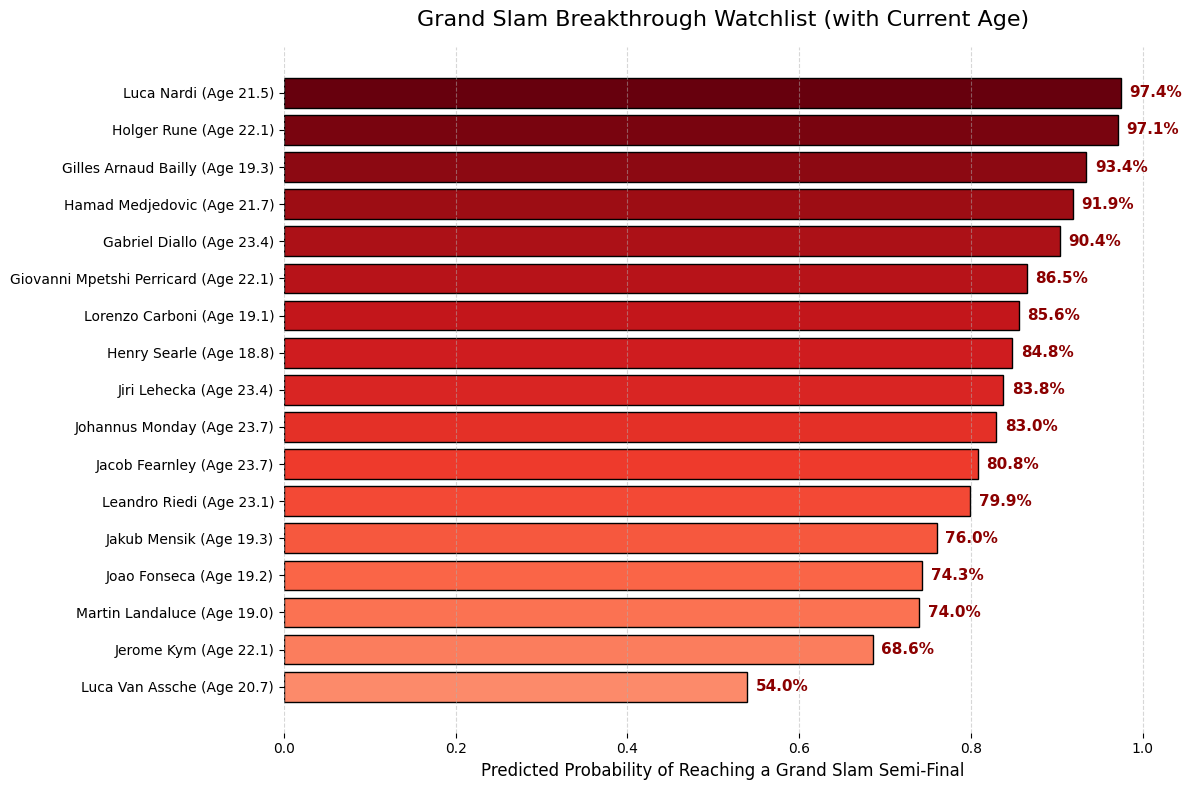

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# === Updated player data with correct names, probabilities, and ages ===
players_data = {
    'name': [
        'Luca Nardi', 'Holger Rune', 'Gilles Arnaud Bailly', 'Hamad Medjedovic',
        'Gabriel Diallo', 'Giovanni Mpetshi Perricard', 'Lorenzo Carboni',
        'Henry Searle', 'Jiri Lehecka', 'Johannus Monday', 'Jacob Fearnley',
        'Leandro Riedi', 'Jakub Mensik', 'Joao Fonseca', 'Martin Landaluce',
        'Jerome Kym', 'Luca Van Assche'
    ],
    'predicted_prob': [
        0.974454, 0.971283, 0.934352, 0.919045, 0.903723, 0.865248,
        0.855616, 0.848077, 0.837749, 0.829896, 0.808109, 0.799366,
        0.760241, 0.743339, 0.739905, 0.685886, 0.539883
    ],
    'Current_Age': [
        21.5, 22.1, 19.3, 21.7, 23.4, 22.1, 19.1, 18.8, 23.4, 23.7,
        23.7, 23.1, 19.3, 19.2, 19.0, 22.1, 20.7
    ]
}
df_top = pd.DataFrame(players_data)

df_top = df_top.drop_duplicates(subset='name', keep='first')


df_top['label'] = df_top.apply(
    lambda row: f"{row['name']} (Age {row['Current_Age']:.1f})", axis=1
)

fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.Reds(np.linspace(1, 0.4, len(df_top)))

bars = ax.barh(df_top['label'], df_top['predicted_prob'], color=colors, edgecolor='black')
ax.set_xlabel('Predicted Probability of Reaching a Grand Slam Semi-Final', fontsize=12)
ax.set_title('Grand Slam Breakthrough Watchlist (with Current Age)', fontsize=16, pad=15)
ax.invert_yaxis()
ax.grid(axis='x', linestyle='--', alpha=0.5)


for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
            f"{width:.1%}", va='center', fontsize=11, fontweight='bold', color='darkred')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.box(False)
plt.tight_layout()
plt.savefig('Grand Slam Breakthrough Watchlist with Current Age.png')
plt.show()